#### Definition
1. mm, s, radian, keV unless specified otherwise in the plot 
3. The coordinate convention of this simulation and its relation to XPP coordinate is 
    (axis 0, axis 1, axis 2) = (vertical, horizontal, propagation) = (xpp y, xpp x, xpp z) 

np.fft(field) = spectrum

np.ifft(spectrum) = field

# Warning 
After moving or changing any optics of 'x' i.e., the XppController, one has to update the efficiency dictionary, which are used to calculate the efficiency and the diode value:

x.update_efficiency_dict()

Otherwise, the diode reading is wrong.

In [1]:
import sys
import time

sys.path.append("../../../")

import numpy as np
import matplotlib.pyplot as plt
from XRaySimulation import util, DeviceSimu, Pulse

import Controller

plt.rcParams.update({'font.size': 12})

# Create the modules for the simulator

In [2]:
# Create a controller object as we have at XPP
x = Controller.XppController()

Create a XA10A motor, moving along x rotation_axis.
Create a XA10A motor, moving along y rotation_axis.
Create a RA10A motor, rotating around y rotation_axis.
Create a SA07A motor, rotating around z rotation_axis.
Create a XA10A motor, moving along x rotation_axis.
Create a XA10A motor, moving along y rotation_axis.
Create a RA10A motor, rotating around y rotation_axis.
Create a SA07A motor, rotating around z rotation_axis.
Create a XA10A motor, moving along x rotation_axis.
Create a XA10A motor, moving along y rotation_axis.
Create a RA10A motor, rotating around y rotation_axis.
Create a SA07A motor, rotating around z rotation_axis.
Create a XA10A motor, moving along x rotation_axis.
Create a XA10A motor, moving along y rotation_axis.
Create a RA10A motor, rotating around y rotation_axis.
Create a SA07A motor, rotating around z rotation_axis.
Create a XA10A motor, moving along x rotation_axis.
Create a XA10A motor, moving along y rotation_axis.
Create a RA10A motor, rotating around y 

# [Preparation] Align everything assume that we have a flat spectrum around the central wave-vector with a bandwidth of 0.5eV

### Align the XPP mono

Motor moved from 0.00000 to -18.27615 degree
Motor moved from 0.00000 to -18.27615 degree


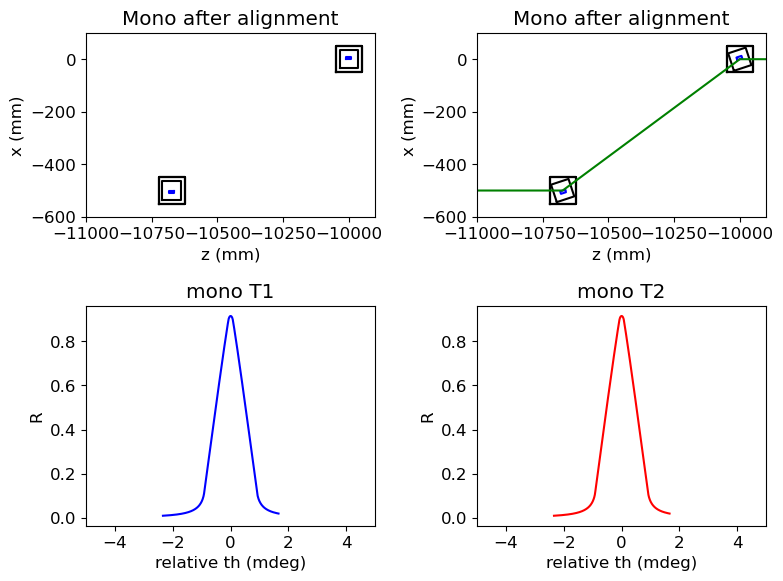

In [3]:
# Prepare a canvas. This section is not important. 
fig, ax = plt.subplots(ncols=2, nrows=2)
fig.set_figheight(6)
fig.set_figwidth(8)

# show mono before alignment
x.plot_mono_optics(ax=ax[0, 0],  xlim=([-11000, -9900]))

# show mono after alignment
_ = x.align_xpp_mono()
x.plot_mono_optics(ax=ax[0, 1], xlim=([-11000, -9900]), show_trajectory=True)
x.plot_mono_rocking(ax_mono_t1=ax[1, 0], ax_mono_t2=ax[1, 1])

plt.tight_layout()
plt.show()

### Align the miniSD assume that the input X-ray pulse has a flat spectrum of 0.5eV

Motor moved from 0.00000 to 19.66038 degree
Motor moved from 0.00000 to 19.64559 degree
Motor moved from 0.00000 to 19.64549 degree
Motor moved from 0.00000 to 19.66108 degree
Motor moved from 0.00000 to 19.66108 degree
Motor moved from 0.00000 to 19.64549 degree


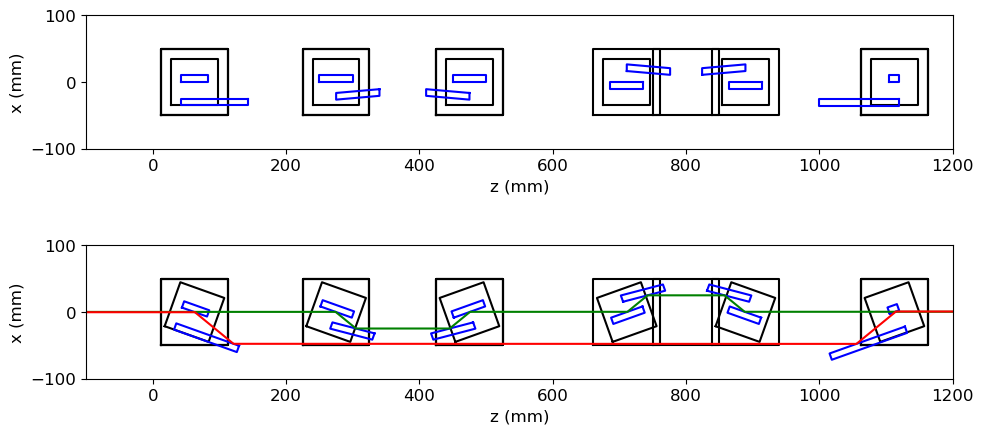

In [4]:
# Prepare a canvas. This section is not important. 
fig, ax = plt.subplots(ncols=1, nrows=2)
fig.set_figheight(5)
fig.set_figwidth(10)

#     Before alignment
x.plot_miniSD_table(ax=ax[0], xlim=None, ylim=None, show_trajectory=False)

#     After alignment
_ = x.align_miniSD()
x.plot_miniSD_table(ax=ax[1], xlim=None, ylim=None, show_trajectory=True)

plt.tight_layout()
plt.show()

Get the most updated rocking curve around current location.


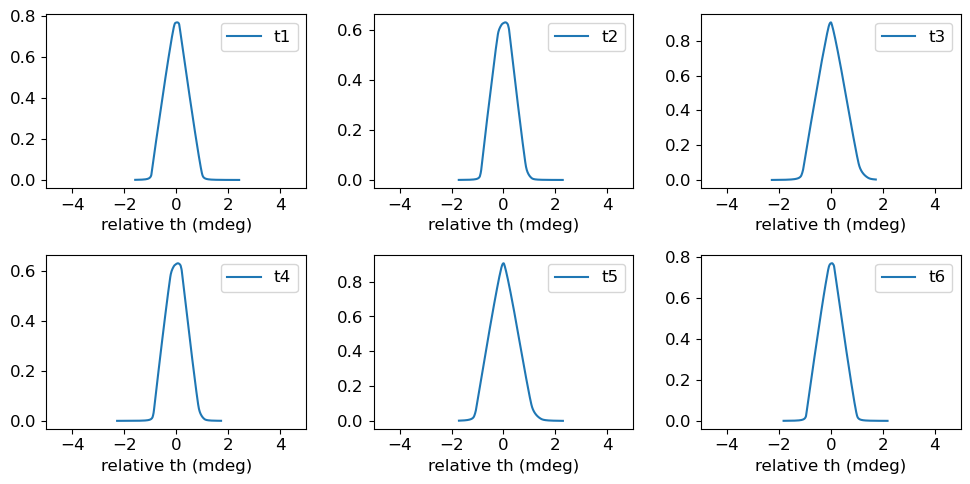

In [5]:
fig, ax = plt.subplots(ncols=3, nrows=2)
fig.set_figheight(5)
fig.set_figwidth(10)

x.plot_miniSD_rocking(ax_list=np.reshape(ax, 6))

plt.tight_layout()
plt.show()

# [Demo] Demonstration of basic functions with this simulation

In [6]:
# Create a SASE pulse source
sase_source = Pulse.saseSource(nx=32, ny=32, nz=1024,
                               dx=4, dy=4, dz=0.1, Ec=9.6,
                               mean_pulse_energy_uJ=600,  # uJ.  10 uJ / 0.5eV * 30 eV = 600 uJ
                               pulse_energy_sigma_uJ=300,
                               # SASE energy fluctuation. Not the fluctuation after the xpp mono
                               n_gaussian=500,
                               mode_size_x=15,
                               mode_size_y=15,
                               mode_size_z=0.15 * util.c,
                               mode_center_spread_x=20,
                               mode_center_spread_y=20,
                               mode_center_spread_z=20 * util.c,
                               x0=np.array([0, -50e3, -30e6]))

The input pulse energy before the XPP mono is 709.00uJ 


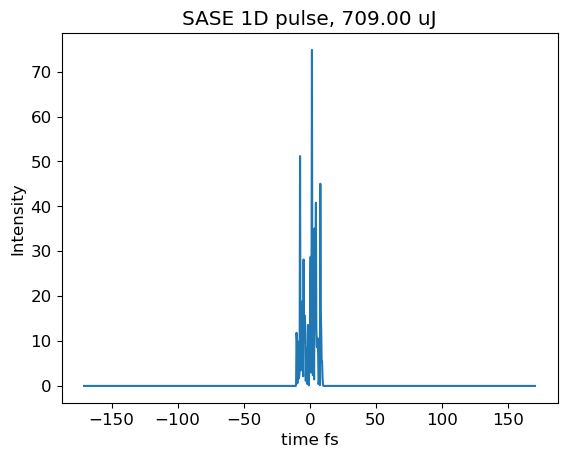

In [7]:
# Get a 1D SASE pulse in tempoeral domain
sase_pulse_1d, pulse_energy_uJ = sase_source.get_sase_1d(randomSeed = 1)
sase_spectrum = np.fft.fftshift(np.fft.fft(np.fft.fftshift(sase_pulse_1d)))  # Get the spectrum

print("The input pulse energy before the XPP mono is {:.2f}uJ ".format(pulse_energy_uJ))
plt.plot(sase_source.tCoor, np.square(np.abs(sase_pulse_1d)))
plt.xlabel("time fs")
plt.ylabel("Intensity")
plt.title("SASE 1D pulse, {:.2f} uJ".format(pulse_energy_uJ))
plt.show()

In [8]:
# Since this is the first time after we change the motor positions/crystal positions, we need to 
# calculate the efficiency of each optics again for the diode reading
## We need to specify the corresponding sase source since we need to match each entry 
## with the correct wave-vector for the efficiency/reflectivity calculation
x.update_efficiency_dict(sase_source = sase_source) 

## Get the photo diode reading from 128 X-ray pulses
pulse_num = 128
pulseholder = np.zeros((128, sase_source.kzCoor.shape[0]), dtype=np.float64)
l3e = np.zeros(pulse_num)
for pulse_idx in range(pulse_num):
    randomSeed = int(time.time() * 1e6) % 65536
    
    sase_pulse_1d, pulse_energy_uJ = sase_source.get_sase_1d(randomSeed = randomSeed)
    l3e[pulse_idx] = pulse_energy_uJ
    
    tmp = np.fft.fftshift(np.fft.fft(np.fft.fftshift(sase_pulse_1d)))
    pulseholder[pulse_idx] = np.square(np.abs(tmp))

In [9]:
# Get a diode reading with the SASE spectrum
## Get the diode reading with only CC branch
#x.show_cc()
## Get the diode reading with only VCC branch
x.show_vcc()
## Get the diode reading with both branches
#x.show_both()

# Please check the source code for the function
# x.get_diode()

diodes_vals = x.get_diode(spectrum_intensity=pulseholder)

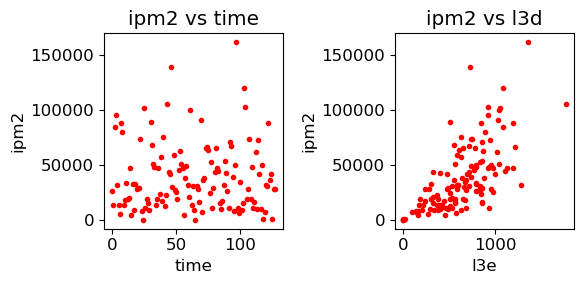

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figheight(3)
fig.set_figwidth(6)

axes[0].plot(np.arange(pulse_num), diodes_vals['ipm2'], color='r', linestyle='', marker='.')
axes[0].set_title("ipm2 vs time")
axes[0].set_xlabel("time")
axes[0].set_ylabel("ipm2")

axes[1].plot(l3e, diodes_vals['ipm2'], color='r', linestyle='', marker='.')
axes[1].set_title("ipm2 vs l3d")
axes[1].set_xlabel("l3e")
axes[1].set_ylabel("ipm2")

plt.tight_layout()
plt.show()

In [11]:
def plot_diodes(diodes_values):
    fig, axes = plt.subplots(ncols=3, nrows=2)
    fig.set_figheight(5)
    fig.set_figwidth(10)
    
    axes[0,0].scatter(diodes_values['ipm2'], diodes_values['d1'], color='r', linestyle='', marker='.')
    axes[0,0].set_title("d1 vs ipm2")
    axes[0,0].set_xlabel("ipm2")
    axes[0,0].set_ylabel("d1")
    
    axes[0,1].scatter(diodes_values['ipm2'], diodes_values['d2'], color='r', linestyle='', marker='.')
    axes[0,1].set_title("d2 vs ipm2")
    axes[0,1].set_xlabel("ipm2")
    axes[0,1].set_ylabel("d2")
    
    axes[0,2].scatter(diodes_values['d1'], diodes_values['d6'], color='r', linestyle='', marker='.')
    axes[0,2].set_title("d6 vs d1")
    axes[0,2].set_xlabel("d1")
    axes[0,2].set_ylabel("d6")
    
    axes[1,0].scatter(diodes_values['d2'], diodes_values['d3'], color='r', linestyle='', marker='.')
    axes[1,0].set_title("d3 vs d2")
    axes[1,0].set_xlabel("d2")
    axes[1,0].set_ylabel("d3")
    
    axes[1,1].scatter(diodes_values['d3'], diodes_values['d4'], color='r', linestyle='', marker='.')
    axes[1,1].set_title("d4 vs d3")
    axes[1,1].set_xlabel("d3")
    axes[1,1].set_ylabel("d4")
    
    axes[1,2].scatter(diodes_values['d4'], diodes_values['d5'], color='r', linestyle='', marker='.')
    axes[1,2].set_title("d5 vs d4")
    axes[1,2].set_xlabel("d4")
    axes[1,2].set_ylabel("d5")
    
    plt.tight_layout()
    plt.show()

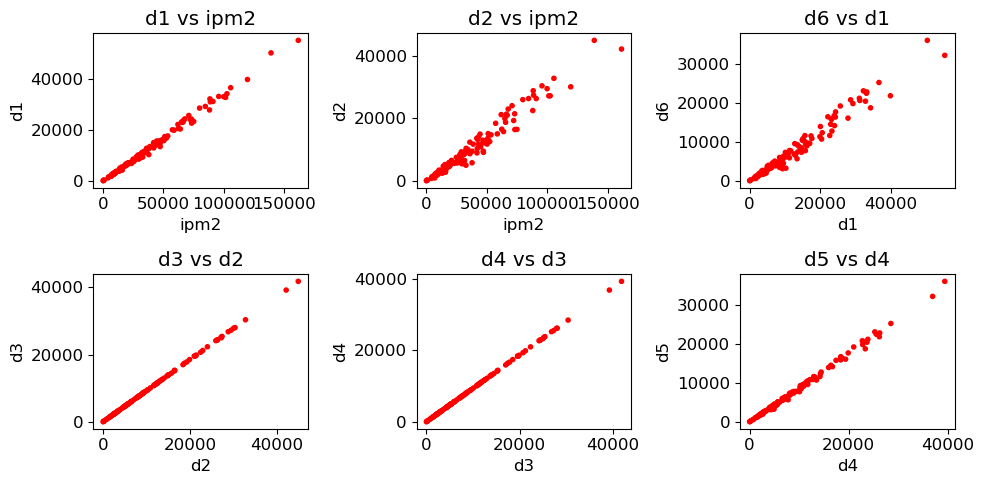

In [12]:
plot_diodes(diodes_values = diodes_vals)

#### This is a sanity check for the efficiency that is used for the calculation of the diode values

In [13]:
"""
fig, axes = plt.subplots(ncols=3, nrows=2)
fig.set_figheight(5)
fig.set_figwidth(10)

axes[0,0].plot(sase_source.EzCoor, x.efficiency_dict['d1'], color='b', linestyle='', marker='.')
axes[0,0].set_xlabel("E eV")
axes[0,0].set_ylabel("efficiency cc1")

axes[0,1].plot(sase_source.EzCoor, x.efficiency_dict['d2'], color='b', linestyle='', marker='.')
axes[0,1].set_xlabel("E eV")
axes[0,1].set_ylabel("efficiency cc2")

axes[0,2].plot(sase_source.EzCoor, x.efficiency_dict['d3'], color='b', linestyle='', marker='.')
axes[0,2].set_xlabel("E eV")
axes[0,2].set_ylabel("efficiency cc3")

axes[1,0].plot(sase_source.EzCoor, x.efficiency_dict['d4'], color='b', linestyle='', marker='.')
axes[1,0].set_xlabel("E eV")
axes[1,0].set_ylabel("efficiency cc4")

axes[1,1].plot(sase_source.EzCoor, x.efficiency_dict['d5'], color='b', linestyle='', marker='.')
axes[1,1].set_xlabel("E eV")
axes[1,1].set_ylabel("efficiency cc5")

axes[1,2].plot(sase_source.EzCoor, x.efficiency_dict['d6'], color='b', linestyle='', marker='.')
axes[1,2].set_xlabel("E eV")
axes[1,2].set_ylabel("efficiency cc6")

plt.tight_layout()
plt.show()
"""

'\nfig, axes = plt.subplots(ncols=3, nrows=2)\nfig.set_figheight(5)\nfig.set_figwidth(10)\n\naxes[0,0].plot(sase_source.EzCoor, x.efficiency_dict[\'d1\'], color=\'b\', linestyle=\'\', marker=\'.\')\naxes[0,0].set_xlabel("E eV")\naxes[0,0].set_ylabel("efficiency cc1")\n\naxes[0,1].plot(sase_source.EzCoor, x.efficiency_dict[\'d2\'], color=\'b\', linestyle=\'\', marker=\'.\')\naxes[0,1].set_xlabel("E eV")\naxes[0,1].set_ylabel("efficiency cc2")\n\naxes[0,2].plot(sase_source.EzCoor, x.efficiency_dict[\'d3\'], color=\'b\', linestyle=\'\', marker=\'.\')\naxes[0,2].set_xlabel("E eV")\naxes[0,2].set_ylabel("efficiency cc3")\n\naxes[1,0].plot(sase_source.EzCoor, x.efficiency_dict[\'d4\'], color=\'b\', linestyle=\'\', marker=\'.\')\naxes[1,0].set_xlabel("E eV")\naxes[1,0].set_ylabel("efficiency cc4")\n\naxes[1,1].plot(sase_source.EzCoor, x.efficiency_dict[\'d5\'], color=\'b\', linestyle=\'\', marker=\'.\')\naxes[1,1].set_xlabel("E eV")\naxes[1,1].set_ylabel("efficiency cc5")\n\naxes[1,2].plot(sa

In [14]:
# Get the beam position on the sample plane
cc_trajectory, cc_kout_array = x.get_raytracing_trajectory(path="cc", get_path_length=False)
vcc_trajectory, vcc_kout_array = x.get_raytracing_trajectory(path="vcc", get_path_length=False)

cc_position = cc_trajectory[-1]
vcc_position = vcc_trajectory[-1]
cc_kout = cc_kout_array[-1]
vcc_kout = vcc_kout_array[-1]

print("The x, y coordinate of the cc pulse on the YAG is um")
print(cc_position[:-1])

print("The x, y coordinate of the vcc pulse on the YAG is um")
print(vcc_position[:-1])

# Get the propagation direction with respect to the z axis
angle_cc = np.rad2deg(np.arctan(cc_kout[:-1] / cc_kout[-1]))
print("The angle between x, y propagation direction of CC pulse w.r.t. z axis is deg")
print(angle_cc)

angle_vcc = np.rad2deg(np.arctan(vcc_kout[:-1] / vcc_kout[-1]))
print("The angle between x, y propagation direction of VCC pulse w.r.t. z axis is deg")
print(angle_vcc)


The x, y coordinate of the cc pulse on the YAG is um
[  0.         489.03248877]
The x, y coordinate of the vcc pulse on the YAG is um
[  0.         776.43673882]
The angle between x, y propagation direction of CC pulse w.r.t. z axis is deg
[0.00000000e+00 2.89091684e-06]
The angle between x, y propagation direction of VCC pulse w.r.t. z axis is deg
[0.00000000e+00 4.21048781e-06]


### Get a reference for the current position of all motors that we need to optimize

In [15]:
# Save a reference for the current position of all theta motors.
t2th_ref = x.t2.th.user_getPosition()
t3th_ref = x.t3.th.user_getPosition()
t2x_ref = x.t2.x.user_getPosition()
t3x_ref = x.t3.x.user_getPosition()
t4th_ref = x.t45.th1.user_getPosition()
t5th_ref = x.t45.th2.user_getPosition()

# [AutoAlignment] Tuning Goal

In [16]:
angle_target = np.copy(angle_vcc)
angle_target[1] += 1e-4

position_target = np.copy(cc_position[:-1])

print("The goal is to change the angle of the VCC pulse from the current value to")
print(angle_target)

print("At the same time, change the position of the VCC pulse to ")
print(position_target)

The goal is to change the angle of the VCC pulse from the current value to
[0.         0.00010421]
At the same time, change the position of the VCC pulse to 
[  0.         489.03248877]


# [Human Strategy] Simplest strategy to achieve the goal, which is not acceptable for its low energy efficiency

Motor moved from 19.64549 to 19.64549 degree
Motor moved from 19.66108 to 19.66108 degree
Motor moved from 19.66108 to 19.66108 degree
Motor moved from 19.64549 to 19.64524 degree
Motor moved from 0.0000 um to to -231.0000 um
Motor moved from 0.0000 um to to 231.0000 um
The new position of the vcc pulse is:
[  0.         489.27737555]
The difference is [0.         0.24488678]
The new angle of the VCC pulse w.r.t. z axis is deg
[0.         0.00010259]
The difference is [ 0.00000000e+00 -1.61571655e-06]


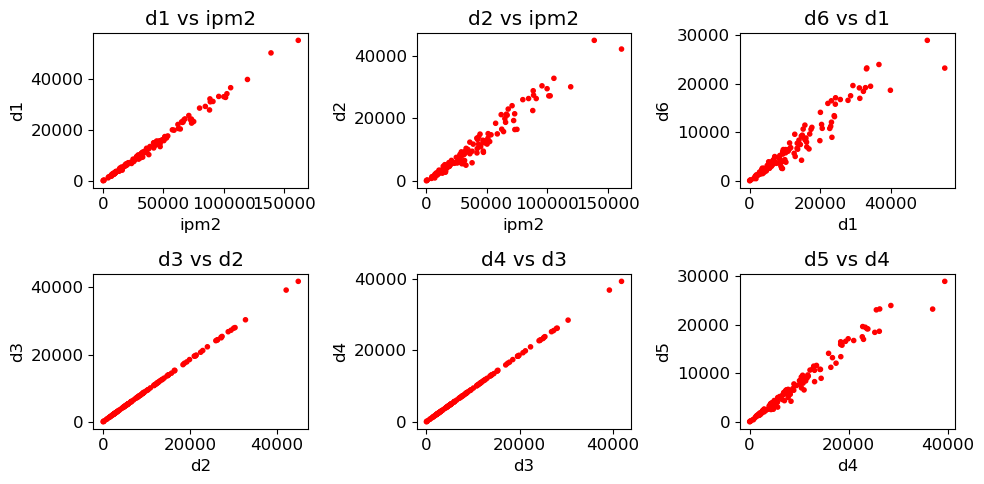

In [17]:
# Move the motors following some strategy
delta = np.deg2rad(-2.5e-4)
delta_vec = [0, 0, 0, delta]

x.t2.th_umv(t2th_ref + delta_vec[0])
x.t3.th_umv(t3th_ref + delta_vec[1])
x.t45.th1_umv(t4th_ref + delta_vec[2])
x.t45.th2_umv(t5th_ref + delta_vec[3])

delta_position = -231
x.t2.x_umv(t2x_ref + delta_position)
x.t3.x_umv(t3x_ref - delta_position)

# Update the efficiency record and correlation curve
x.update_efficiency_dict(sase_source = sase_source) 
diodes_vals_new = x.get_diode(spectrum_intensity=pulseholder)

# Get the new position 
vcc_trajectory_new, vcc_kout_array_new = x.get_raytracing_trajectory(path="vcc", get_path_length=False)
vcc_position_new = vcc_trajectory_new[-1]
vcc_kout_new = vcc_kout_array_new[-1]

print("The new position of the vcc pulse is:")
print(vcc_position_new[:-1])
print("The difference is", vcc_position_new[:-1] - position_target)

# Get the new angle
angle_vcc_new = np.rad2deg(np.arctan(vcc_kout_new[:-1] / vcc_kout_new[-1]))
print("The new angle of the VCC pulse w.r.t. z axis is deg")
print(angle_vcc_new)
print("The difference is", angle_vcc_new - angle_target)

# Show the correlation curve
plot_diodes(diodes_values = diodes_vals_new)

# [Human Strategy] Current strategy to achieve the goal

Motor moved from 19.64549 to 19.64549 degree
Motor moved from 19.66108 to 19.66120 degree
Motor moved from 19.66108 to 19.66108 degree
Motor moved from 19.64524 to 19.64536 degree
Motor moved from -231.0000 um to to -242.0000 um
Motor moved from 231.0000 um to to 242.0000 um
The new position of the vcc pulse is:
[  0.        475.5454058]
The difference is [  0.         -13.48708297]
The new angle of the VCC pulse w.r.t. z axis is deg
[0.         0.00010259]
The difference is [ 0.00000000e+00 -1.61666102e-06]


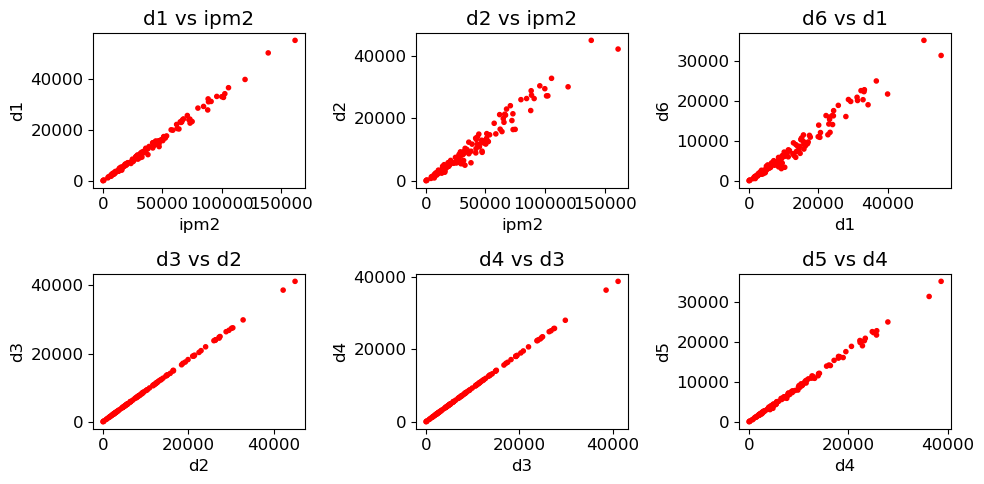

In [18]:
# Move the motors following some strategy
delta = np.deg2rad(-1.25e-4)
delta_vec = [0, -delta, 0, delta]

x.t2.th_umv(t2th_ref + delta_vec[0])
x.t3.th_umv(t3th_ref + delta_vec[1])
x.t45.th1_umv(t4th_ref + delta_vec[2])
x.t45.th2_umv(t5th_ref + delta_vec[3])

delta_position = -242  # um
x.t2.x_umv(t2x_ref + delta_position)
x.t3.x_umv(t3x_ref - delta_position)

# Update the efficiency record and correlation curve
x.update_efficiency_dict(sase_source = sase_source) 
diodes_vals_new = x.get_diode(spectrum_intensity=pulseholder)

# Get the new position 
vcc_trajectory_new, vcc_kout_array_new = x.get_raytracing_trajectory(path="vcc", get_path_length=False)
vcc_position_new = vcc_trajectory_new[-1]
vcc_kout_new = vcc_kout_array_new[-1]

print("The new position of the vcc pulse is:")
print(vcc_position_new[:-1])
print("The difference is", vcc_position_new[:-1] - position_target)

# Get the new angle
angle_vcc_new = np.rad2deg(np.arctan(vcc_kout_new[:-1] / vcc_kout_new[-1]))
print("The new angle of the VCC pulse w.r.t. z axis is deg")
print(angle_vcc_new)
print("The difference is", angle_vcc_new - angle_target)

# Show the correlation curve
plot_diodes(diodes_values = diodes_vals_new)

# Target for the project: Find a strategy better than the current strategy

In [19]:
# 1: Higher intensity of the pulse i.e., higher d5 value on average
# 2: The position accuracy should be better than 6.5um / 20 = 325 nm
# 3: The angular accuracy should be better than 30 nrad = 2e-6 deg 
# 4: The position motion accuracy is 1 um. i.e., one should not ask the x.t2.x_umv to
#       move to a position with an accuracy better than 1um. There was a noise added to the motor motion. 
#       I have removed that feature to make it easier to start. One therefore should impose this requirement by oneself.
# 5: The angular motion accuracy is 1e-5 deg. For now, one may assume that one can use 1e-6 deg to start with to 
#       find out the best performance of this setup.